In [92]:
# Author: Antti Kiviaho
# Date: 10.5.2023

import os 
os.chdir('/lustre/scratch/kiviaho/prostate_spatial')
import numpy as np
import scanpy as sc
import pandas as pd
import seaborn as sns
import anndata as ad

from scipy.stats import chisquare
from datetime import datetime
import igraph as ig


import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")


## Function definitions

In [93]:
def score_modules(ctype, genes_dict):
    dat = sc.read_h5ad('nmf_annotation/run_20230712/'+ ctype + '.h5ad')
    dat.X = dat.layers['counts'].copy()

    for k in genes_dict.keys():
        lst = genes_dict[k]

        # Score the gene expression data.
        sc.tl.score_genes(dat, gene_list=lst, score_name=k, ctrl_size=len(lst), random_state=3523569)

    # Find the column with the highest score and add a new column for the corresponding module.
    score_cols = list(genes_dict.keys())

    max_col = dat.obs[score_cols].idxmax(axis=1)
    dat.obs['max_scoring'] = max_col

    #obs_data = dat.obs.copy()

    return(dat)


def calculate_phenotype_distributions(df,module):

    # Phenotype proportions in the celltype as a whole
    bground_proportions = df['phenotype'].value_counts()/len(df)
    order = bground_proportions.index

    # The number of cells scoring highest on this module
    subset = df[df['max_scoring'] == module]
    # Expected proportions based on the celltype proportions
    expected = bground_proportions*len(subset)

    observed = subset['phenotype'].value_counts()[order]

    contig_table = pd.DataFrame({'expected':expected.astype(int),
    'observed':observed,
    'diff':observed-expected.astype(int)})

    pval = chisquare(observed,expected).pvalue

    print(module+': top scoring in ' + str(len(subset))+' cells')
    print(contig_table)
    print('chi2 test p-value: ' + str(pval))
    print('')

    
def plot_score_violins(scores_df,group_col='max_scoring'):
    # Take all columns with module in their name
    module_columns = [col for col in scores_df.columns if 'module' in col]
    module_columns.append(group_col)

    if len(module_columns) > 0:
        violin_df = scores_df[module_columns]

        rows = len(module_columns)//2
        fig, axs = plt.subplots(rows, 2, figsize=(20, 5 * rows))

        for i in range(len(module_columns)-1): # Don't plot the last column
            row = i // 2
            col = i % 2
            
            sns.violinplot(data=violin_df, x=group_col, y=module_columns[i], ax=axs[row][col],order=list(violin_df.drop(columns='max_scoring').columns))
            axs[row][col].tick_params(axis='x', rotation=30)

            # Get the 1st quantile of highest scoring module
            val_80 = violin_df.loc[violin_df[group_col] == module_columns[i],module_columns[i]].quantile(q=0.25)

            # Add horizontal line
            axs[row][col].axhline(y=val_80, color='black', linestyle='--')

        
        plt.show()
    else:
        print("No columns found with 'module' in their names.")


def save_dict_to_excel(dict_with_modules,ctype):
    # Saves the factors to a dataframe and onto an excel sheet
    max_length = max(len(lst) for lst in dict_with_modules.values())
    for key in dict_with_modules:
        dict_with_modules[key].extend([np.nan]*(max_length - len(dict_with_modules[key])))

    df_with_modules = pd.DataFrame.from_dict(dict_with_modules)
    df_with_modules.to_excel(ctype+'_modules_'+datetime.today().strftime('%Y%m%d')+'.xlsx')
    

def create_modules_from_adjacency_matrix(celltype,min_modules_per_connection=4,
                                         min_connections_per_gene=4,min_genes_in_module=10,
                                         plot_clustermap=True, random_seed=235693923):
    
    import random
    random.seed(random_seed)#235693923 used in september. The previous iteration did not have a seed
    '''
    This is a function that takes an adjacency matrix of gene connections as 
    input and generates clusters of genes using the Leiden algorithm implemented 
    in the python module igraph. The clusters are then filtered and returned in the
    form of a dictionary with keys as module indexes and values as lists of gene
    names. The function includes a number of default arguments, such as minimum
    number of modules per connection (5), minimum number of connections per gene (5),
    minimum number of genes in a module (10), and a boolean flag to indicate whether
    to plot a clustermap using seaborn (True). The function works by filtering the 
    adjacency matrix to remove weak connections, then using the igraph module to group
    the genes in clusters. The clusters are filtered for minimum size and sorted by size.
    The resulting gene modules are returned as a dictionary, and a seaborn clustermap is
    plotted if desired.
    '''
    adj_df = pd.read_csv('nmf_annotation/run_20230712/'+celltype+'_nmf_derived_gene_adjacencies.csv',index_col=0)

    # Filter connections occurring in fewer than n factors
    adj_df[adj_df<=min_modules_per_connection] = 0 # Note that the threshold is included in the filtering here

    # Filter genes with less than n connections
    adj_df = adj_df[adj_df.astype(bool).sum(axis=1) >= min_connections_per_gene]

    # Filter the columns as well
    adj_df = adj_df[adj_df.index] 

    # create graph object
    g = ig.Graph.Adjacency(np.matrix(adj_df),mode='undirected')

    # find clusters
    clusters = g.community_leiden()

    # Extract cluster labels and link them to genes (index)
    labels = pd.Series(clusters.membership)
    labels.index = adj_df.index.copy()

    # Filter the modules by minimum number of genes present and sort them by the number of genes 
    labels_to_keep = list(labels.value_counts()[pd.Series(labels).value_counts() >= min_genes_in_module].index)



    # Save the genes of each module (cluster) to a dictionary
    modules = {}
    for idx,l in enumerate(labels_to_keep):

        # Sort the genes by max values: decreasing
        sorted_genes = list(adj_df[list(adj_df[labels == l].index)].max().sort_values()[::-1].index)
        modules['module'+str(idx)] = sorted_genes
        #modules['module'+str(idx)] = list(adj_df[labels == l].index)

    adj_df = adj_df[[value for key in modules for value in modules[key]]]
    adj_df = adj_df.loc[[value for key in modules for value in modules[key]]]

    if plot_clustermap:
        sns.clustermap(adj_df, cmap='magma', figsize=(6,6),row_cluster=False,col_cluster=False,
                       vmax=np.quantile(np.matrix(adj_df),0.99))


    # Return the dictionary
    return(modules, adj_df)


## Annotating immune cells

Ran celltypist in 'single-cell-immune-celltypist' notebook (7.9.2023)

In [94]:
immune_cell_annotations = pd.read_csv('./celltypist_dir/celltypist_predicted_labels_20230907.csv',index_col=0)
immune_cell_annotations['predicted_labels']


GSM4089152_P2_AACTCTTAGCAGATCG.1     Macrophages
GSM4089152_P2_AACTTTCTCCTCGCAT.1     Macrophages
GSM4089152_P2_AATCCAGGTTGCTCCT.1     Macrophages
GSM4089152_P2_ACCAGTATCGTTTATC.1     Macrophages
GSM4089152_P2_ACGAGCCCACGAAGCA.1     Macrophages
                                        ...     
SCG-PCA22-T-HG_TTTGTCAGTCTAGGTT-1        T cells
SCG-PCA22-T-HG_TTTGTCAGTGGGTCAA-1        T cells
SCG-PCA22-T-HG_TTTGTCAGTGGTTTCA-1        B cells
SCG-PCA22-T-HG_TTTGTCAGTTTAGCTG-1        T cells
SCG-PCA22-T-HG_TTTGTCATCATTTGGG-1        T cells
Name: predicted_labels, Length: 98662, dtype: object

In [95]:
# Create a dataframe for final annotations of all cells
final_annotations = pd.DataFrame()
final_annotations = pd.concat([final_annotations,immune_cell_annotations['predicted_labels']],axis=0)

## Revising the NMF strategy

The full list of modules obtained for individual tumors was filtered to retain only those with at least 5% overlap (by Jaccard index) with at least two other modules. An adjacency matrix was then constructed connecting genes according to the number of individual tumor modules in which they co-occur. Gene–gene connections were filtered out if they occurred in fewer than two individual tumor modules, and genes with fewer than three connections were removed. The graph was clustered using infomap clustering implemented in the igraph package v.1.2.11 (ref. 93). Finally, modules with potential biological relevance were retained by filtering out those with fewer than five genes or without significant overlap with gene ontology terms. The final graph (Extended Data Fig. 3f) was visualized with the Fruchterman–Reingold layout.

- Methods from Barkley et al. Nat. Genetics 2022

## Loading the NMF gene lists and scoring them

### Epithelial

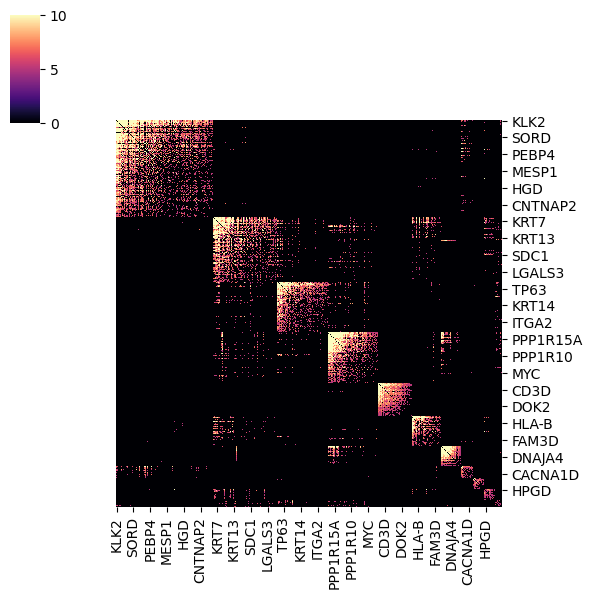

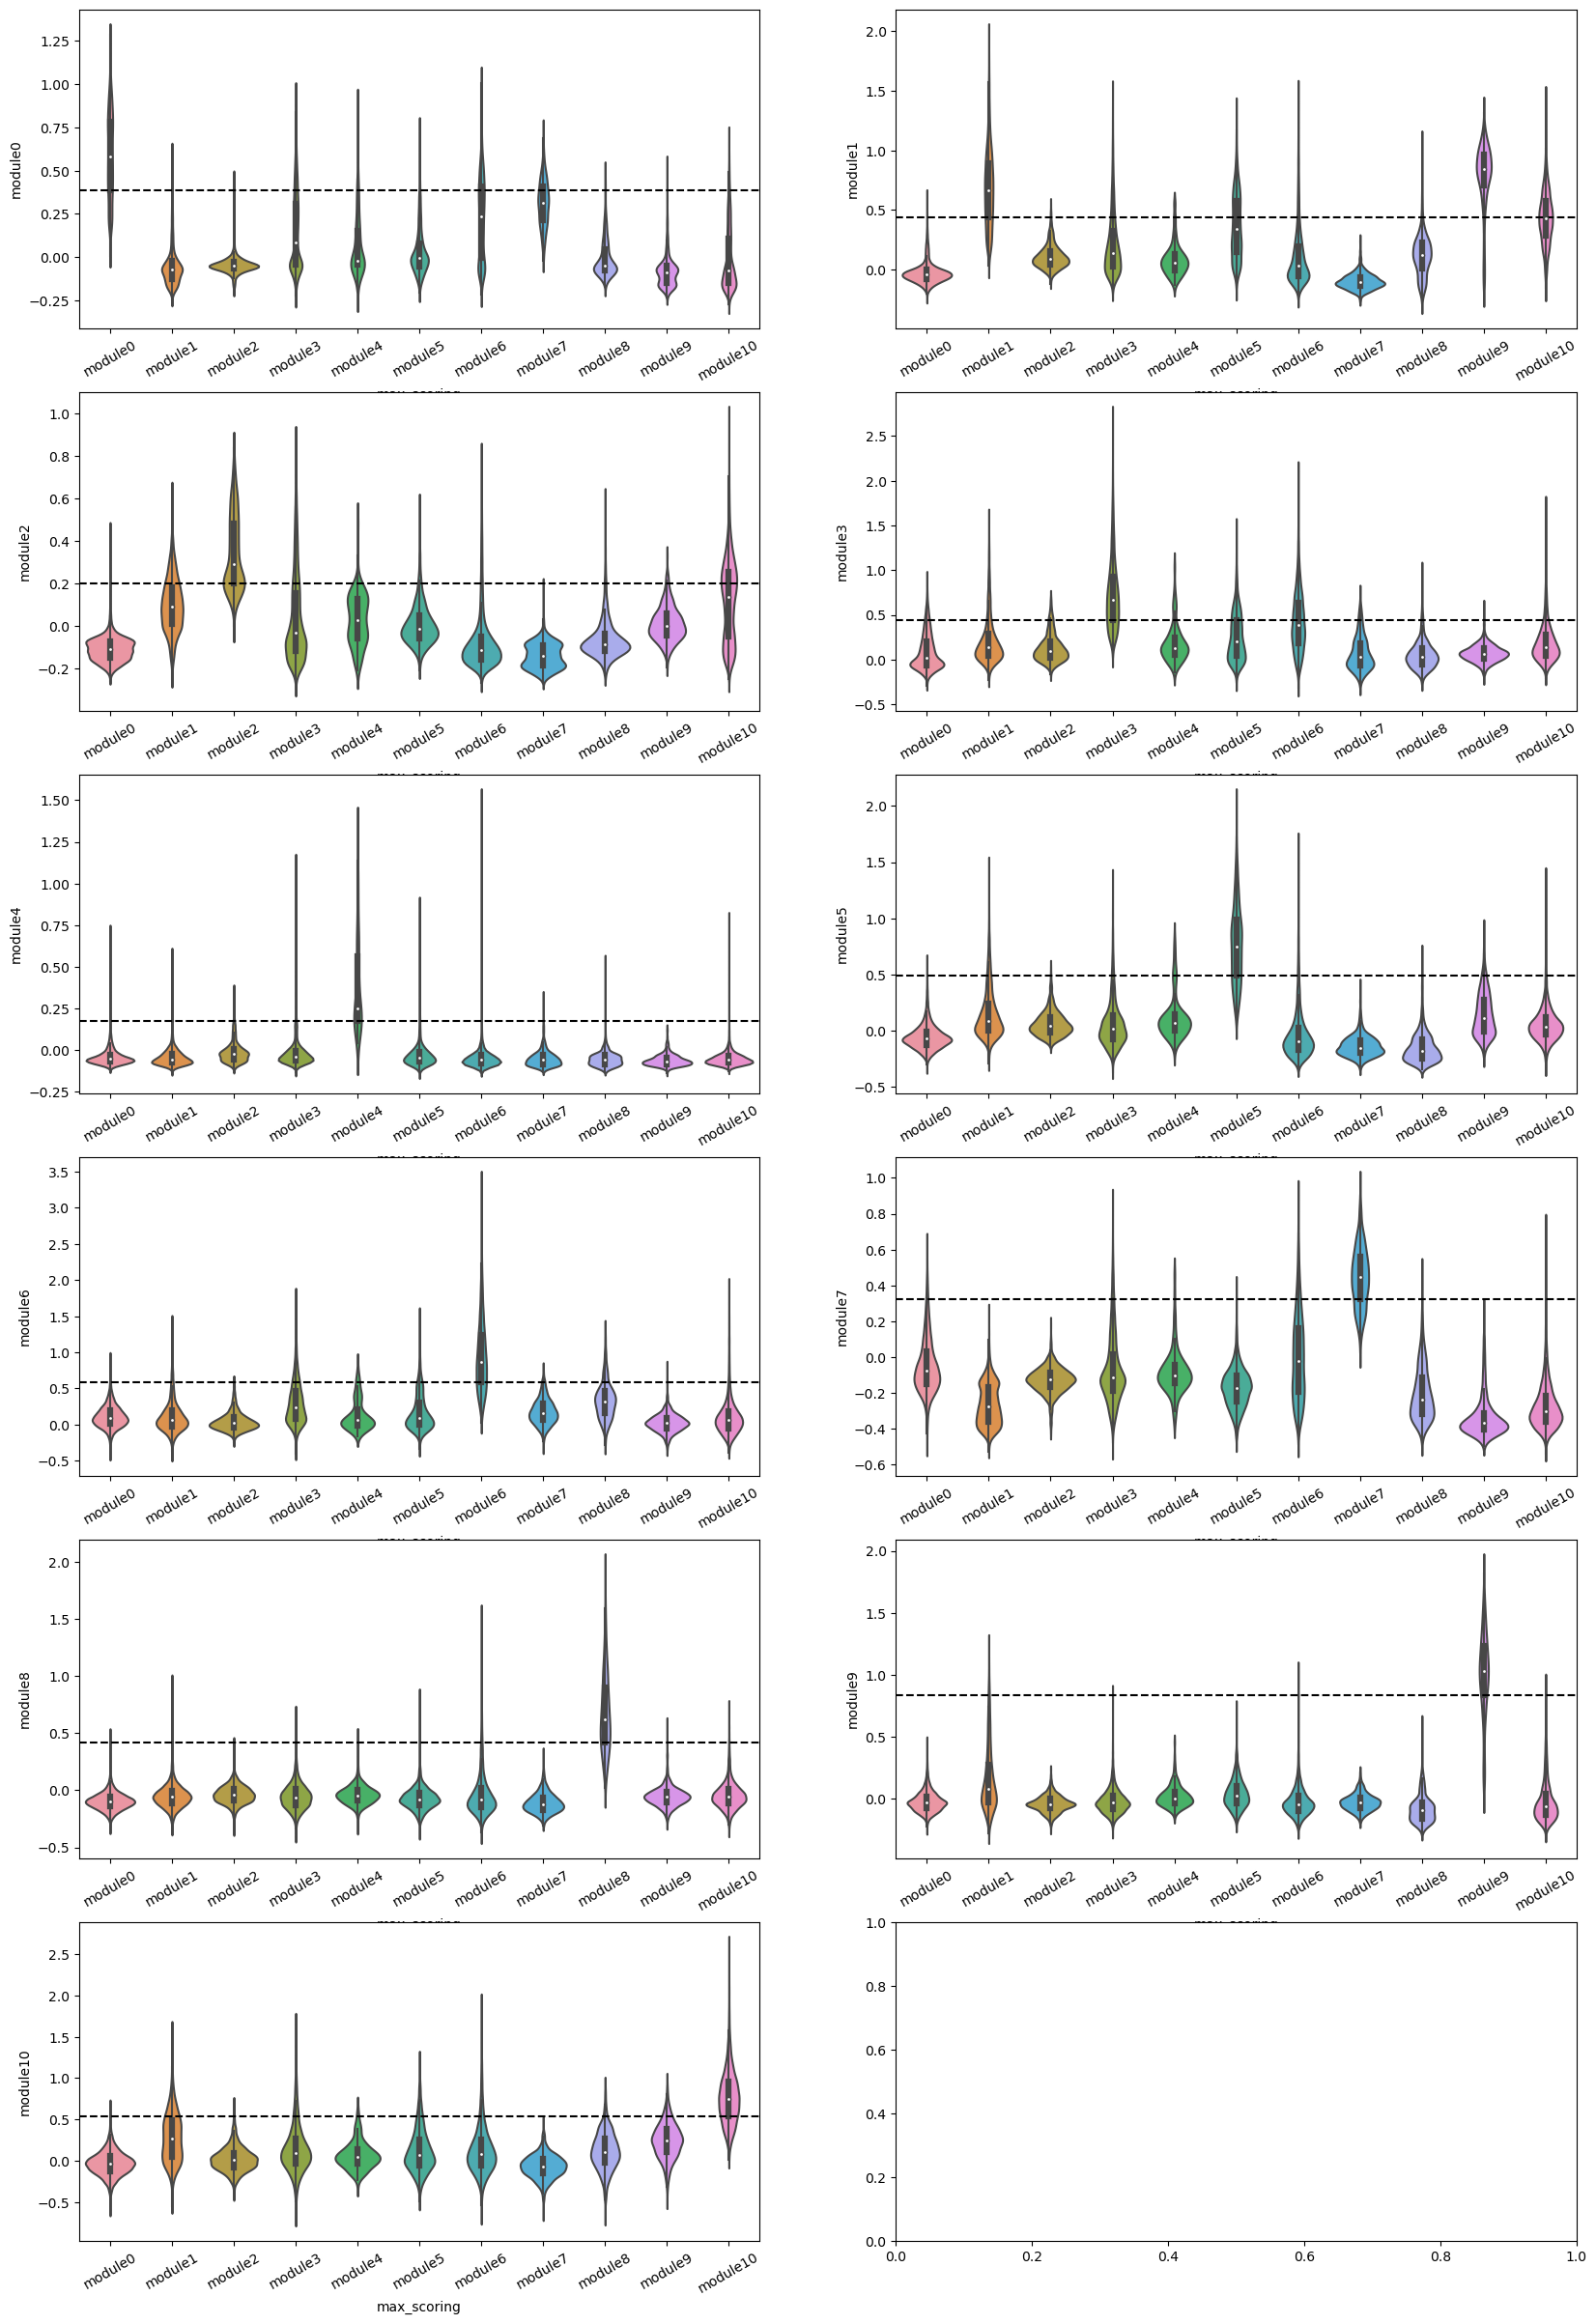

In [96]:
epithelial_modules, adjacency_df = create_modules_from_adjacency_matrix('Epithelial',min_modules_per_connection=4,min_connections_per_gene=4,random_seed=217644)
dat = score_modules('Epithelial',epithelial_modules)
epithelial_scores = dat.obs.copy()
 
plot_score_violins(epithelial_scores)


In [97]:
keep_track = []
for g1 in adjacency_df.max().sort_values()[::-1][:10].index:
    g2 = adjacency_df[g1].idxmax()
    if (g1 not in keep_track) & (g2 not in keep_track):
        print(g1 + ' <--> ' + g2 + ': '+ str(adjacency_df[g1].max()))
        keep_track.append(g1)
        keep_track.append(g2)

KLK2 <--> KLK3: 38
ACPP <--> RDH11: 34
EGR1 <--> FOSB: 33
JUNB <--> FOS: 32
CD74 <--> HLA-DRA: 32


In [98]:
for module in list(epithelial_modules.keys()):
    calculate_phenotype_distributions(epithelial_scores,module)

module0: top scoring in 24820 cells
        expected  observed  diff
PCa        15812     13211 -2601
normal      5664     11435  5771
CRPC        3342       174 -3168
chi2 test p-value: 0.0

module1: top scoring in 11801 cells
        expected  observed  diff
PCa         7518      7047  -471
normal      2693      1901  -792
CRPC        1589      2853  1264
chi2 test p-value: 7.499006573796279e-276

module2: top scoring in 2114 cells
        expected  observed  diff
PCa         1346      1174  -172
normal       482       905   423
CRPC         284        35  -249
chi2 test p-value: 1.76240504644583e-133

module3: top scoring in 13662 cells
        expected  observed  diff
PCa         8704     10341  1637
normal      3117      2520  -597
CRPC        1840       801 -1039
chi2 test p-value: 7.140869496664655e-220

module4: top scoring in 198 cells
        expected  observed  diff
PCa          126       139    13
normal        45        53     8
CRPC          26         6   -20
chi2 test p

In [99]:
# Rename the columns accordingly
replacements = {'module0':'luminal epithelium', 'module1':'sensescent epithelium',
                'module2':'basal epithelium', 'module3':'stress signaling epithelium',
                'module4':'drop','module5':'club_interferon response epithelium',
                'module6':'chaperone response epithelium','module7':'tumor',
                'module8':'cycling epithelium 1','module9':'cycling epithelium 2',
                'module10':'FOSL1 related epithelium'
                }


for k in list(replacements.keys()):
    epithelial_scores['max_scoring'] = epithelial_scores['max_scoring'].replace(k, replacements[k])

In [100]:
final_annotations = pd.concat([final_annotations,epithelial_scores['max_scoring']],axis=0)

### Fibroblast_muscle

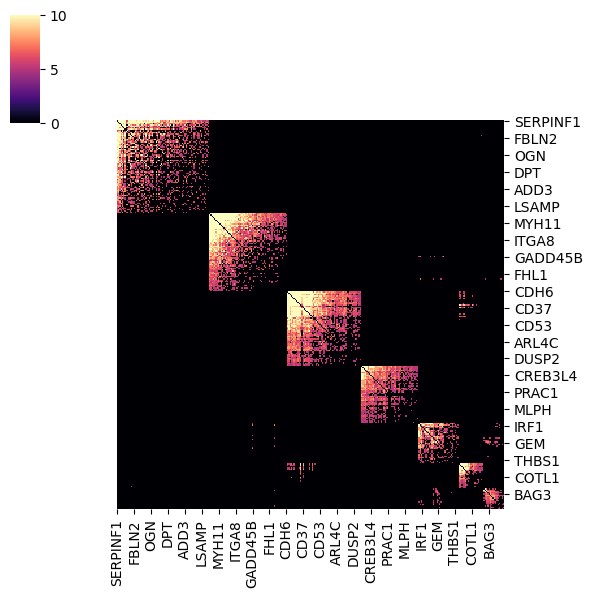

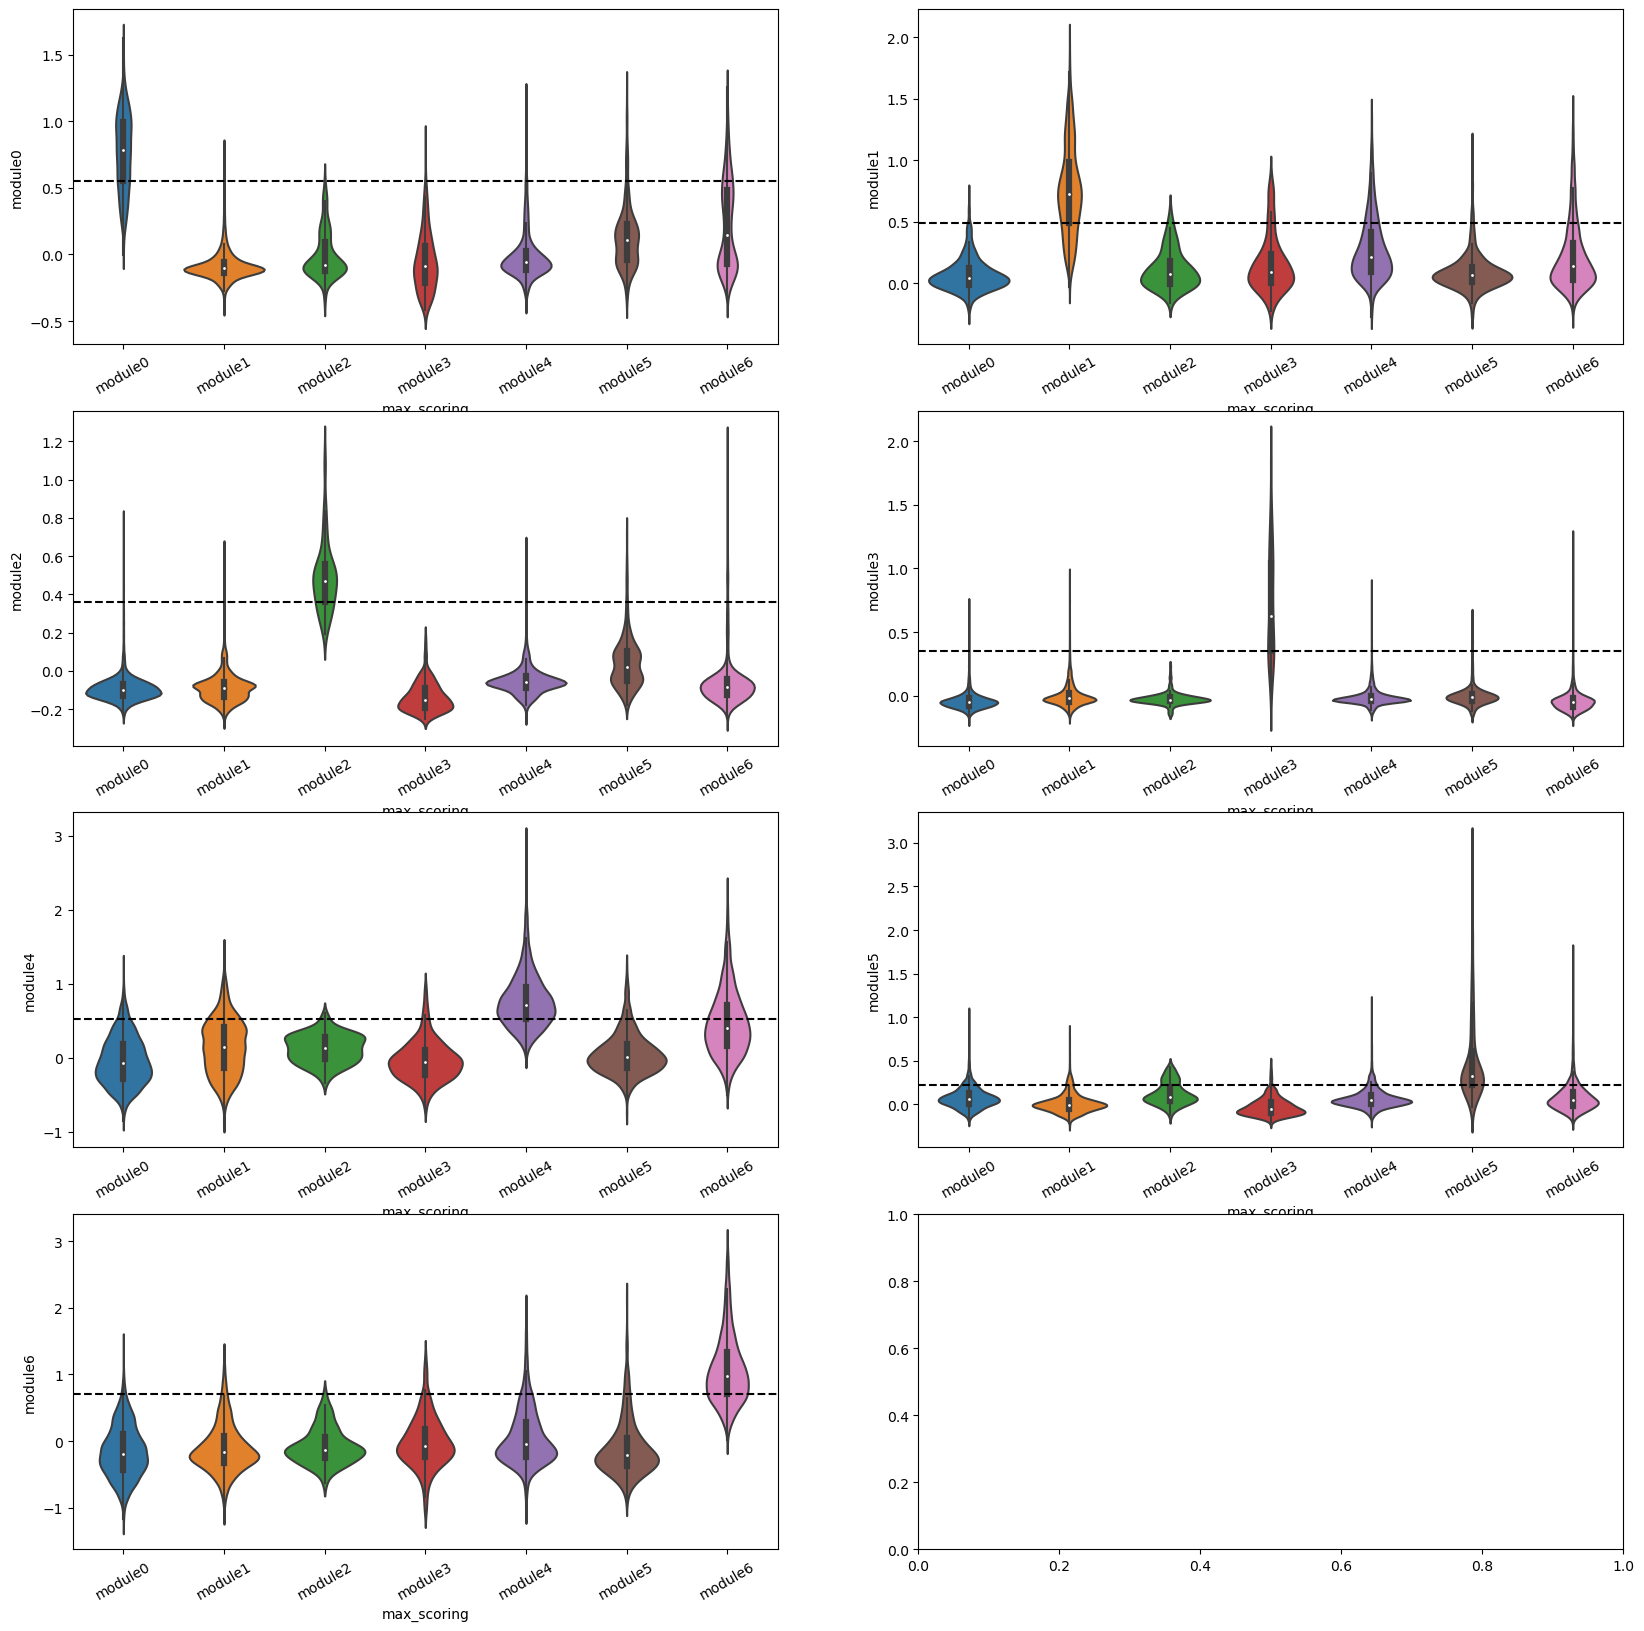

In [101]:
fibro_modules,adjacency_df = create_modules_from_adjacency_matrix('Fibroblast_muscle',min_modules_per_connection=4,min_connections_per_gene=4,random_seed =23526235)

dat = score_modules('Fibroblast_muscle',fibro_modules)
fibro_scores = dat.obs.copy()

plot_score_violins(fibro_scores)

In [102]:
for module in list(fibro_modules.keys()):
    calculate_phenotype_distributions(fibro_scores,module)

module0: top scoring in 4951 cells
        expected  observed  diff
PCa         2370      1562  -808
normal      1718      2375   657
CRPC         862      1014   152
chi2 test p-value: 5.459985488327347e-121

module1: top scoring in 6676 cells
        expected  observed  diff
PCa         3196      3776   580
normal      2316      1854  -462
CRPC        1162      1046  -116
chi2 test p-value: 4.063257458685032e-46

module2: top scoring in 147 cells
        expected  observed  diff
PCa           70        75     5
normal        51        61    10
CRPC          25        11   -14
chi2 test p-value: 0.00503554202868241

module3: top scoring in 314 cells
        expected  observed  diff
PCa          150       166    16
normal       108        47   -61
CRPC          54       101    47
chi2 test p-value: 2.9777961965053073e-17

module4: top scoring in 4791 cells
        expected  observed  diff
PCa         2294      2463   169
normal      1662      2113   451
CRPC         834       215  -619

In [103]:
# Rename the columns accordingly
replacements = {'module0':'fibroblast', 'module1':'muscle',
                'module2':'drop', 'module3':'drop',
                'module4':'stress response fibroblasts','module5':'drop',
                'module6':'chaperone response fibroblasts'
                }


for k in list(replacements.keys()):
    fibro_scores['max_scoring'] = fibro_scores['max_scoring'].replace(k, replacements[k])

final_annotations = pd.concat([final_annotations,fibro_scores['max_scoring']],axis=0)

### Endothelial

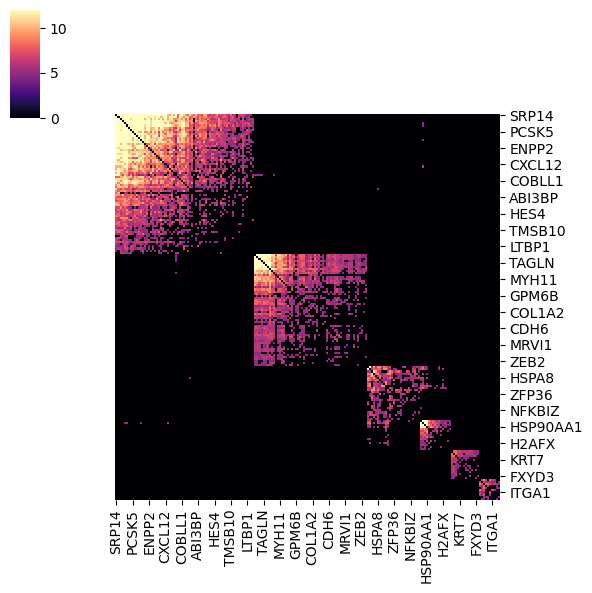

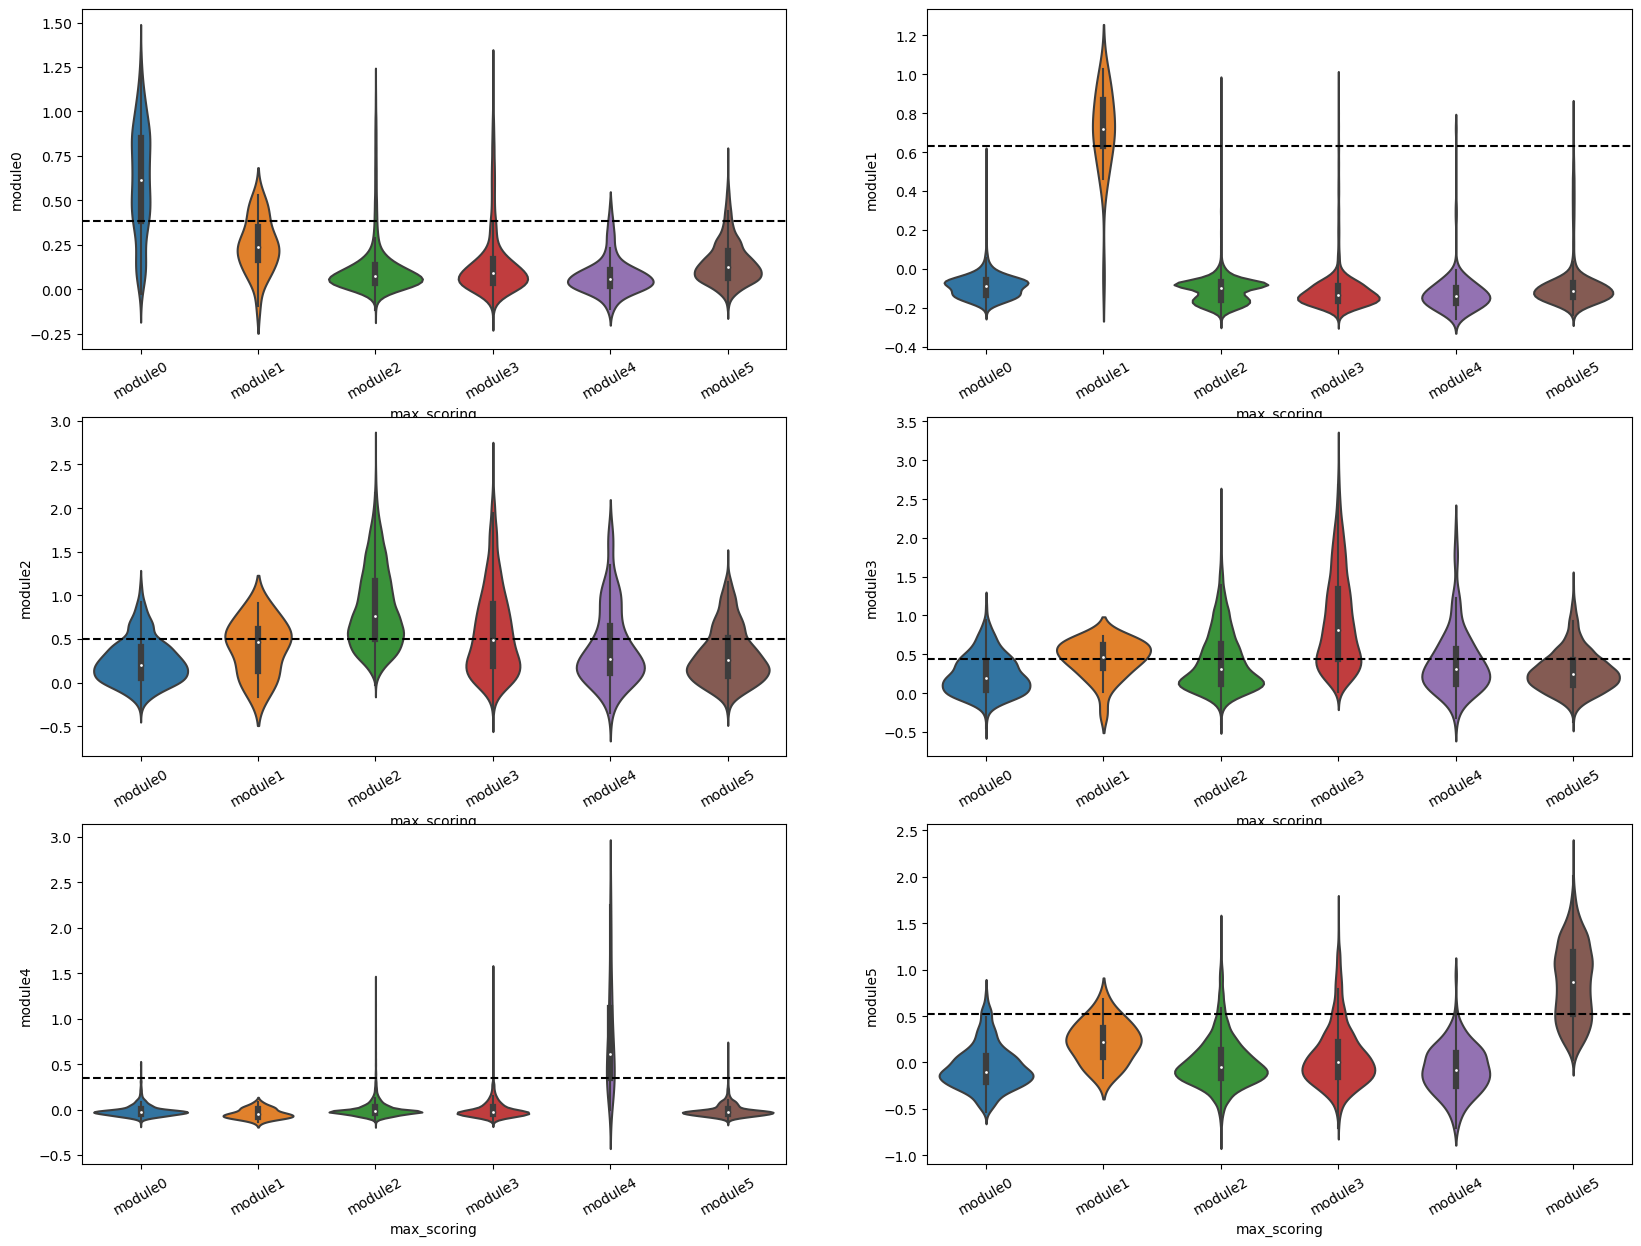

In [104]:
endo_modules, adjacency_df = create_modules_from_adjacency_matrix('Endothelial',min_modules_per_connection=4,min_connections_per_gene=4,random_seed=4607345)
dat = score_modules('Endothelial',endo_modules)

endothelial_scores = dat.obs.copy()

plot_score_violins(endothelial_scores)


In [105]:
for module in list(endo_modules.keys()):
    calculate_phenotype_distributions(endothelial_scores,module)

module0: top scoring in 843 cells
        expected  observed  diff
PCa          538       587    49
normal       257       233   -24
CRPC          47        23   -24
chi2 test p-value: 5.541052807325935e-05

module1: top scoring in 26 cells
        expected  observed  diff
PCa           16        14    -2
normal         7         8     1
CRPC           1         4     3
chi2 test p-value: 0.09412428144860648

module2: top scoring in 14099 cells
        expected  observed  diff
PCa         8999      8730  -269
normal      4299      4853   554
CRPC         800       516  -284
chi2 test p-value: 7.752002852740064e-40

module3: top scoring in 4654 cells
        expected  observed  diff
PCa         2970      2927   -43
normal      1419      1115  -304
CRPC         264       612   348
chi2 test p-value: 1.5058468088793754e-114

module4: top scoring in 157 cells
        expected  observed  diff
PCa          100       104     4
normal        47        29   -18
CRPC           8        24    16


In [106]:
# Rename the columns accordingly
					
replacements = {'module0':'drop','module1':'drop',
                'module2':'capillary venous endothelium','module3':'chaperone response endothelium',
                'module4':'drop','module5':'angiogenic endothelium'
}


for k in list(replacements.keys()):
    endothelial_scores['max_scoring'] = endothelial_scores['max_scoring'].replace(k, replacements[k])

final_annotations = pd.concat([final_annotations,endothelial_scores['max_scoring']],axis=0)

### Save the gene modules into an excel table

In [ ]:
# Save cell type modules to dict
ctypes_gene_modules_dict = {'Epithelial':pd.DataFrame.from_dict(epithelial_modules,orient='index').T,
                            'Fibroblast_muscle':pd.DataFrame.from_dict(fibro_modules,orient='index').T,
                            'Endothelial':pd.DataFrame.from_dict(endo_modules,orient='index').T}

# Save the results into an excel-file

# Create a Pandas Excel writer using the file name
writer = pd.ExcelWriter('./supplementary_tables/nmf_based_gene_annotations.xlsx', engine='xlsxwriter')

# Iterate through each key-value pair in the dictionary
for key, value in ctypes_gene_modules_dict.items():
    # Write each dataframe to a separate sheet in the Excel file
    value.to_excel(writer, sheet_name=key)

# Save and close the Excel writer
#writer.save()

## Merging annotations with data

In [107]:
# Load the data
adata = sc.read_h5ad('aggregate_sc_data_with_broad_annotation_20230712.h5ad')
adata.X = adata.layers['counts'].copy()
del adata.layers['counts']

In [108]:
# Add the neuronal annotated cells as they were neither immune nor included in the NMF processing
neuronal = adata.obs[adata.obs['refined_celltypes']=='Neuronal']['refined_celltypes']
final_annotations = pd.concat([final_annotations,neuronal],axis=0)


In [109]:
# Rename the final_annotations columns
final_annotations = final_annotations.rename(columns={0:'final_annotation'})

In [110]:
adata = adata[final_annotations.index]

if (adata.obs.index == final_annotations.index).all():
    adata.obs['final_annotation'] = final_annotations['final_annotation'].copy()
    print('Done')



Done


In [111]:
# Removing the cells with nan as cell type reference
adata = adata[~adata.obs['final_annotation'].isna()]

# Removing factors that were top scorers in less than 100 cells
adata = adata[~(adata.obs['final_annotation']=='drop')]


In [112]:
adata

View of AnnData object with n_obs × n_vars = 223881 × 14819
    obs: 'sample', 'patient', 'celltype_orig', 'phenotype', 'dataset', 'total_counts', 'n_counts', 'n_genes', 'VI_clusters', 'refined_celltypes', 'final_annotation'
    uns: 'hvg'
    obsm: 'X_scVI', 'X_umap'
    obsp: 'connectivities', 'distances'

In [113]:
# Finished, annotated data
print(adata.obs['final_annotation'].value_counts())
print('')
print('The total number of different celltypes: ' + str(len(adata.obs['final_annotation'].unique())))

T cells                                71600
luminal epithelium                     24820
capillary venous endothelium           14099
stress signaling epithelium            13662
chaperone response epithelium          12891
sensescent epithelium                  11801
B cells                                11686
FOSL1 related epithelium               10606
muscle                                  6676
ILC                                     5359
fibroblast                              4951
Mast cells                              4885
stress response fibroblasts             4791
chaperone response endothelium          4654
club_interferon response epithelium     3845
chaperone response fibroblasts          3248
angiogenic endothelium                  2971
Macrophages                             2952
basal epithelium                        2114
cycling epithelium 2                    1399
cycling epithelium 1                    1116
tumor                                   1082
Monocytes 

In [ ]:
#adata.write('./single_cell_reference_with_nmf_derived_annotations_'+datetime.today().strftime('%Y%m%d')+'.h5ad')

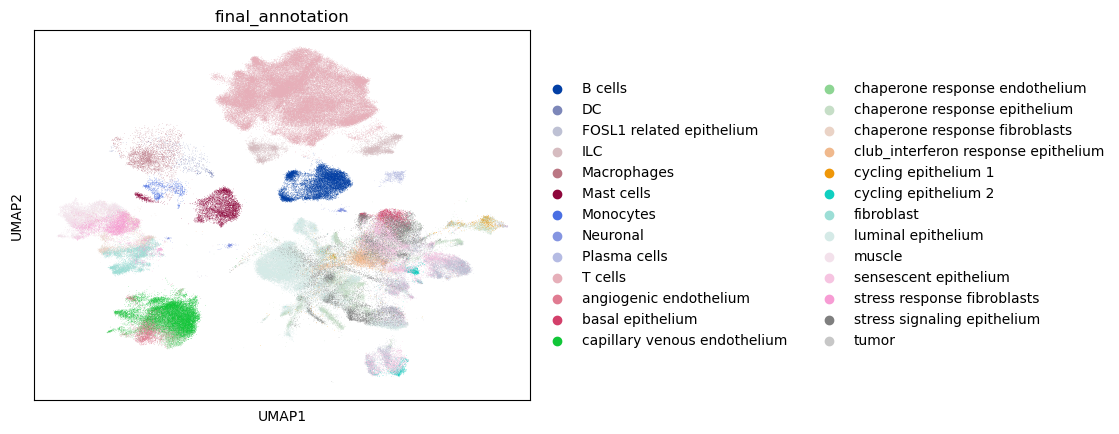

In [114]:
sc.pl.umap(adata,color='final_annotation')